# Laboratorium 11 - Spadek wzdłuż gradientu

In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import copy
from scipy.optimize import golden
from itertools import cycle

In [2]:
labels = pd.read_csv("breast-cancer.labels", header=None, names=["name"])
column_names = labels["name"].tolist()


train_data = pd.read_csv("breast-cancer-train.dat", header=None, names=column_names)
validate_data = pd.read_csv(
    "breast-cancer-validate.dat", header=None, names=column_names
)

In [3]:
# Reprezentacja liniowa
A_train_linear = train_data.drop(["patient ID", "Malignant/Benign"], axis=1).values
A_validate_linear = validate_data.drop(
    ["patient ID", "Malignant/Benign"], axis=1
).values

# Reprezentacja kwadratowa
selected_features = [
    "radius (mean)",
    "perimeter (mean)",
    "area (mean)",
    "symmetry (mean)",
]


def create_quadratic_features(data):
    quadratic_features = data[selected_features].copy()
    for feature in selected_features:
        quadratic_features[f"{feature}^2"] = data[feature] ** 2
    for i in range(len(selected_features)):
        for j in range(i + 1, len(selected_features)):
            feature1 = selected_features[i]
            feature2 = selected_features[j]
            quadratic_features[f"{feature1}*{feature2}"] = (
                data[feature1] * data[feature2]
            )
    return quadratic_features.values


A_train_quadratic = create_quadratic_features(train_data)
A_validate_quadratic = create_quadratic_features(validate_data)

In [4]:
# Wektor b dla zbioru treningowego
b_train = np.array(
    [[1, 0] if row == "M" else [0, 1] for row in train_data["Malignant/Benign"]]
)

# Wektor b dla zbioru walidacyjnego
b_validate = np.array(
    [[1, 0] if row == "M" else [0, 1] for row in validate_data["Malignant/Benign"]]
)

In [5]:
def classify(W, X):
    S = X @ W
    return S == np.max(S, axis=1, keepdims=True)

In [6]:
def calc_acc(P, T):
    accuracy = np.sum(P * T) / P.shape[0]
    return 100.0 * accuracy


def print_log(step, cost, train_acc, val_acc):
    log = (
        "Step {:3d}\tcost value: {:5.2f},\ttrain accuracy: {:5.2f},\t"
        "validation accuracy: {:5.2f}"
    )
    log = log.format(step, cost.item(), train_acc.item(), val_acc.item())

    print(log)


In [7]:
def mse(S, T):
    return 0.5 * np.mean((S - T) ** 2)

def grad_mse(X, S, T):
    n =  X.shape[0]
    return (1.0 / n) * X.T @ (S - T)

In [8]:
def gd_fit(W0, X, T, X_val, T_val, lr=1.0, steps=100, log_every=5):
    n = X.shape[0]
    W = np.copy(W0)
    M = 0
    mu = 0.9

    stats = []

    for step in range(steps):
        S = X @ W
        cost_val = mse(S, T)

        cost_grad = grad_mse(X, S, T)
        M = mu * M - lr * cost_grad
        W = W + M

        P_train = classify(W, X)
        train_acc = calc_acc(P_train, T)

        P_val = classify(W, X_val)
        val_acc = calc_acc(P_val, T_val)

        stats.append((cost_val, train_acc, val_acc))
        if step == 0 or (step + 1) % log_every == 0:
            print_log(step + 1, cost_val, train_acc, val_acc)

    return W, stats

In [9]:
ATA_eigenvalues, _ = np.linalg.eig(A_train_linear.T @ A_train_linear)
lambda_min = np.min(ATA_eigenvalues)
lambda_max = np.max(ATA_eigenvalues)
condition_no = lambda_max / lambda_min


In [10]:
X = np.column_stack([A_train_linear, np.full(A_train_linear.shape[0], 1)])
T = b_train
X_val = np.column_stack([A_validate_linear, np.full(A_validate_linear.shape[0], 1)])
T_val = b_validate

print(X.shape, T.shape, X_val.shape, T_val.shape)

(300, 31) (300, 2) (260, 31) (260, 2)


In [11]:
#W0 = np.random.randn(31, 2)
W0 = np.zeros((31, 2))
# print(X)
# print(W0)
# print(softmax(X @ W0))


Learning rate:  3.667777291369401e-08
Step   1	cost value:  0.25,	train accuracy: 48.67,	validation accuracy: 23.08
Step  50	cost value:  0.13,	train accuracy: 48.67,	validation accuracy: 23.08
Step 100	cost value:  0.12,	train accuracy: 48.67,	validation accuracy: 23.46
Step 150	cost value:  0.12,	train accuracy: 56.67,	validation accuracy: 31.92
Step 200	cost value:  0.11,	train accuracy: 73.33,	validation accuracy: 56.92
Step 250	cost value:  0.11,	train accuracy: 81.67,	validation accuracy: 68.08
Step 300	cost value:  0.11,	train accuracy: 86.00,	validation accuracy: 76.54
Step 350	cost value:  0.11,	train accuracy: 90.00,	validation accuracy: 80.38
Step 400	cost value:  0.10,	train accuracy: 92.00,	validation accuracy: 85.38
Step 450	cost value:  0.10,	train accuracy: 91.67,	validation accuracy: 87.69
Step 500	cost value:  0.10,	train accuracy: 92.00,	validation accuracy: 90.00
Step 550	cost value:  0.10,	train accuracy: 92.00,	validation accuracy: 91.15
Step 600	cost value:  0.10

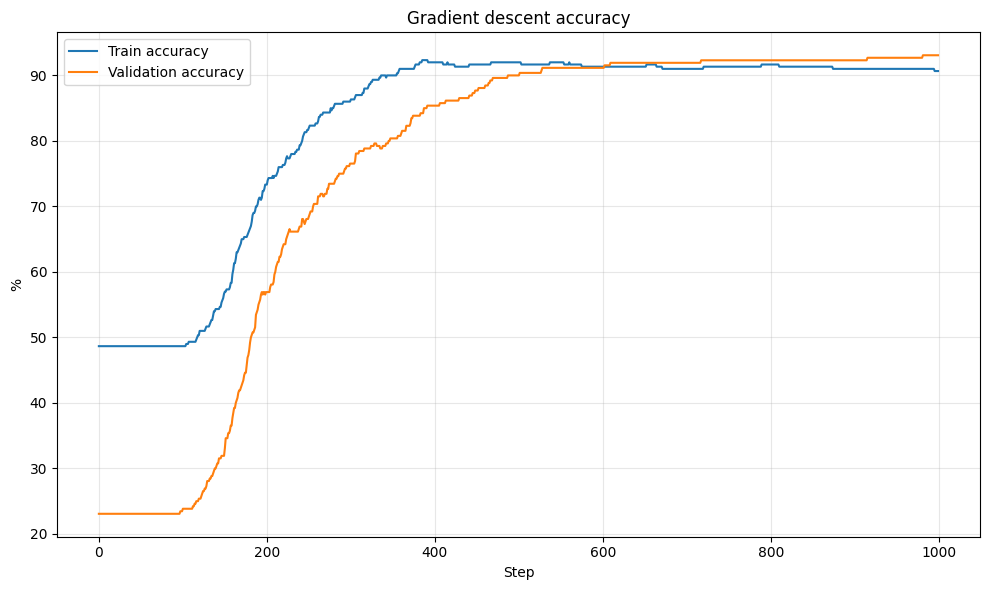

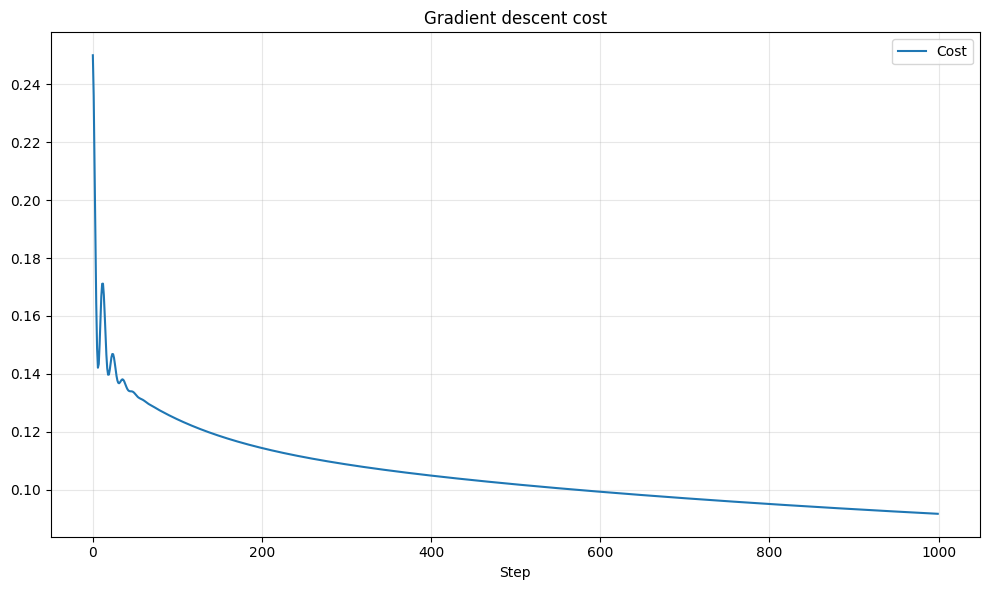

In [12]:
# Another try with higher learning rate
lr = 20 / (lambda_max)

print("Learning rate: ", lr)
W, stats = gd_fit(W0, X, T, X_val, T_val, lr=lr, steps=1000, log_every=50)


cost = [t[0] for t in stats]
t_acc = [t[1] for t in stats]
v_acc = [t[2] for t in stats]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each series
plt.plot(t_acc, label="Train accuracy")
plt.plot(v_acc, label="Validation accuracy")

# Customize the plot
plt.xlabel("Step")
plt.ylabel("%")
plt.title("Gradient descent accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()


# Create the plot
plt.figure(figsize=(10, 6))

# Plot each series
plt.plot(cost, label="Cost")

# Customize the plot
plt.xlabel("Step")
plt.title("Gradient descent cost")
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

# Zadanie 2.

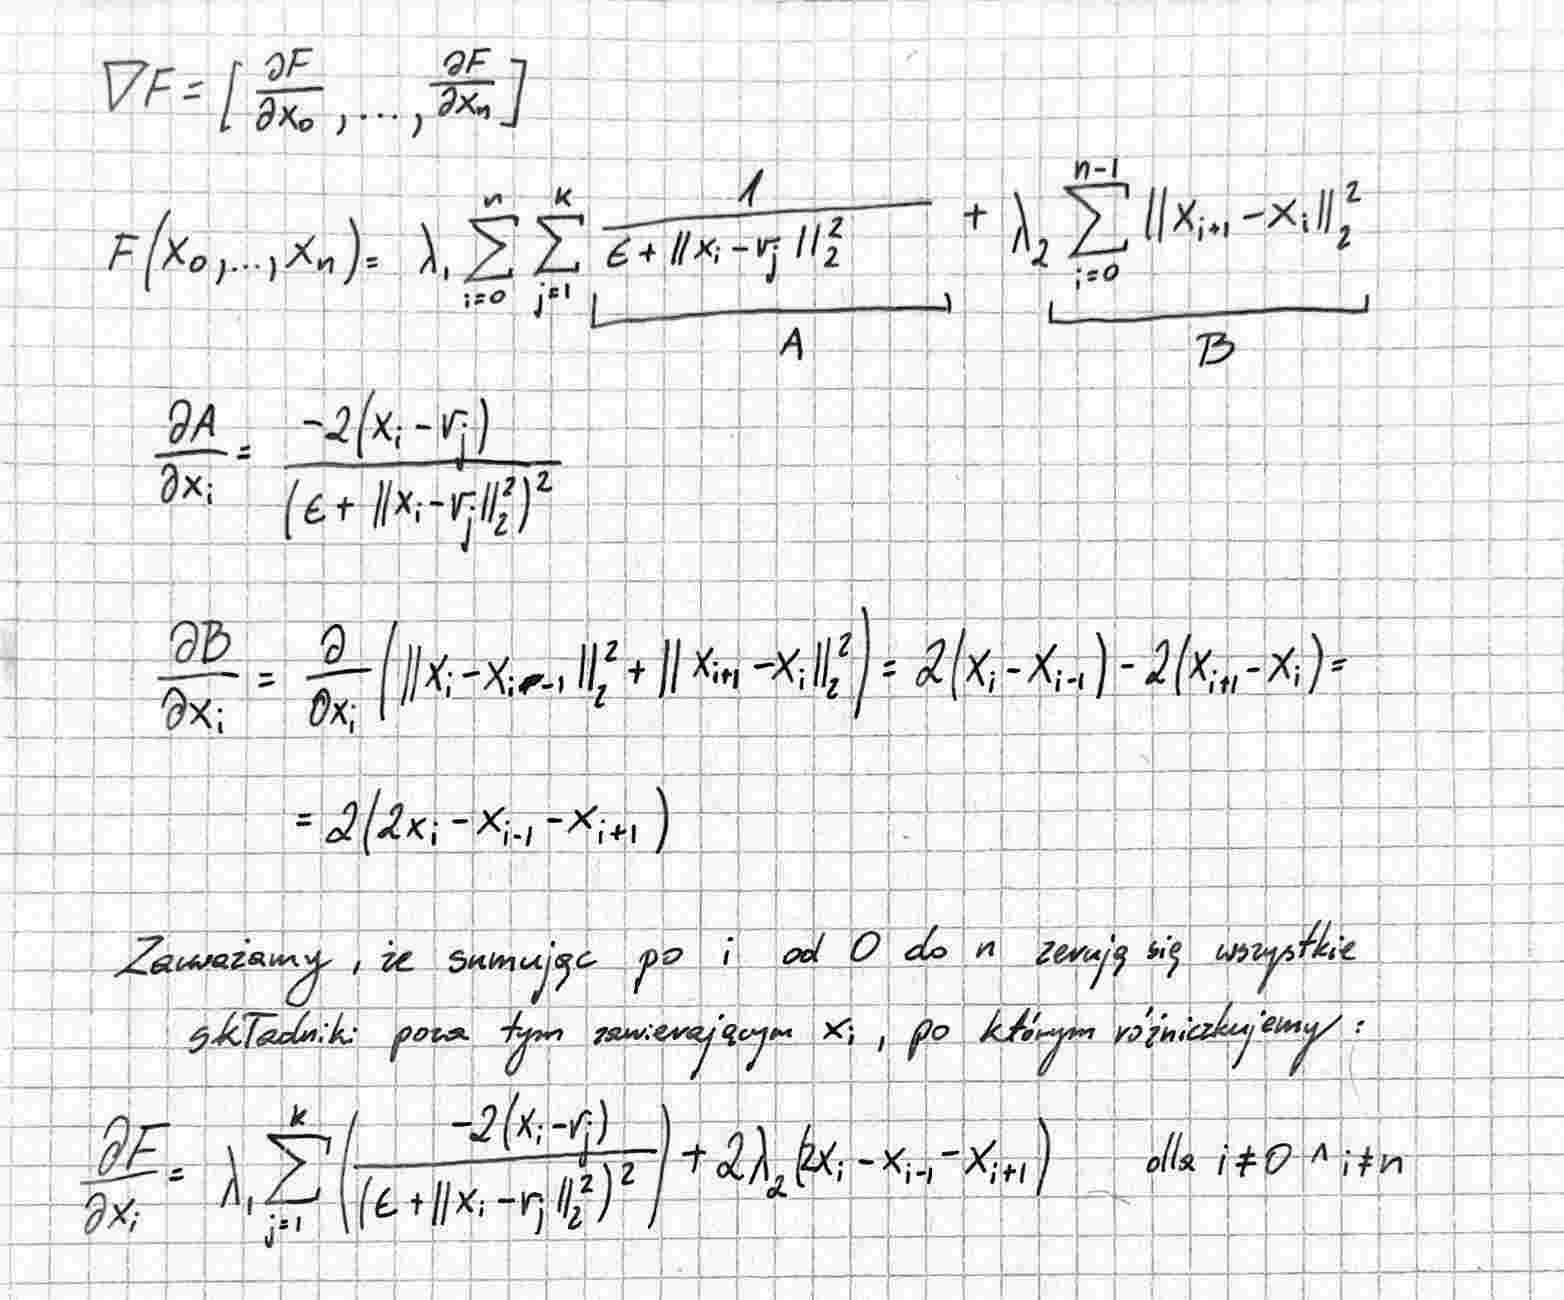

In [13]:
np.random.seed(1234)

n = 20
k = 50
x_0 = [0, 0]
x_n = [20, 20]
R = np.random.uniform(0, 20, (k, 2))
l_1 = l_2 = 1.
eps = 10e-13
iterations = 400

In [14]:
def cost(X):
    R_prim = R[1:]
    A = np.sum(1 / (eps + np.square(np.linalg.norm(np.tile(X[:, np.newaxis, :], (1, R_prim.shape[0], 1)) - R_prim, axis=2))))
    B = np.sum(np.square(np.linalg.norm(X[1:] * X[:-1], axis=1)))

    return l_1 * A + l_2 * B

In [15]:
def grad_cost(X):
    R_prim = R[1:]
    diff = np.tile(X[:, np.newaxis, :], (1, R_prim.shape[0], 1)) - R_prim # diff_i_j = X_i - R_j
    A = -2 * l_1 * np.sum(diff / (eps + np.square(np.linalg.norm(diff, axis=2)))[:, :, np.newaxis], axis=1)
    B = np.zeros_like(X)
    B[1:-1] = 2 * l_2 * (2 * X[1:-1] - X[:-2] - X[2:])

    return A + B

In [16]:
def line_search(X):
    costs = []
    copyX = copy.deepcopy(X)
    
    def helper(xs, grad):
        return lambda alpha: cost(xs + alpha * grad)

    for i in range(iterations):
        costs.append(cost(copyX))
        grad = grad_cost(copyX)
        alpha = golden(helper(copyX, grad))

        print(f"Step: {i}, Alpha: {alpha}, Cost: {cost(copyX)}, Grad Norm: {np.linalg.norm(grad)}")

        copyX += alpha * grad
        
        if np.linalg.norm(grad * alpha) < eps:
            break

    return (copyX, costs)


In [17]:
XS = []
costs = []
results = []

for i in range(5):
    X = np.vstack((x_0, np.random.uniform(0, 20, (n - 1, 2)), x_n))

    XS.append(X)

    (result, res_cost) = line_search(X)
    results.append(result)
    costs.append(res_cost)

    next_seed = np.random.randint(0, 1000)
    np.random.seed(next_seed)

Step: 0, Alpha: -0.42899904899187136, Cost: 748860.4940659179, Grad Norm: 171.45114872571065
Step: 1, Alpha: 0.02153313629988781, Cost: 514645.22272025637, Grad Norm: 295.15648600337454
Step: 2, Alpha: -0.0007843613368855345, Cost: 499760.13072514726, Grad Norm: 340.2366957942302
Step: 3, Alpha: 2.227570461557691e-05, Cost: 499730.5468276434, Grad Norm: 338.1772688998042
Step: 4, Alpha: -5.59493628087823e-07, Cost: 499730.52339857596, Grad Norm: 338.23534770082557
Step: 5, Alpha: 1.4385578417355037e-08, Cost: 499730.52338376304, Grad Norm: 338.2338886385551
Step: 6, Alpha: 5.739741553745436e-16, Cost: 499730.52338375425, Grad Norm: 338.2339261534462
Step: 0, Alpha: -0.059713472219930626, Cost: 408455.47619261494, Grad Norm: 110.5237214355361
Step: 1, Alpha: -0.03747368755596471, Cost: 402921.60340501193, Grad Norm: 76.80572306155672
Step: 2, Alpha: -0.016971558340852518, Cost: 401206.5776210827, Grad Norm: 62.700188689870465
Step: 3, Alpha: -0.01614702853125785, Cost: 400922.2307544282

In [18]:
print(results)

[array([[-1.74797422, -2.22059556],
       [ 5.53813615, -0.09723929],
       [22.36292551,  5.53599881],
       [ 1.72663235, 16.44604812],
       [14.41389053, 10.89250471],
       [ 1.17568546,  1.33280424],
       [ 3.69588963, 29.37519939],
       [16.15057139, -3.38119443],
       [ 2.88945195, 14.32766182],
       [25.81333399, 11.86818024],
       [ 6.83090072,  9.40227231],
       [20.12748984, 12.79377702],
       [ 8.90325874,  8.76809253],
       [14.44892612, 18.30493169],
       [-0.79657784, -5.10215128],
       [ 8.71686462, 19.29621002],
       [ 9.78532694, -1.81498726],
       [-2.28396973,  7.30452274],
       [30.69946665,  3.3177742 ],
       [ 6.93951534, 15.4954624 ],
       [22.44160975, 22.15119206]]), array([[-0.58998347, -0.74421474],
       [ 5.35049588,  0.81715762],
       [ 5.6551005 ,  5.89938521],
       [ 8.86474159, 13.36928456],
       [ 4.84057265, 15.37817253],
       [ 2.19594644, 14.75192445],
       [ 3.54914034,  8.52145548],
       [ 6.599848